# Import bibliotek

In [1]:
import json
import string
import morfeusz2
import numpy as np
import pandas as pd
import operator as op
import itertools as it
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import PlaintextCorpusReader
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Korpus dokumentów

In [63]:
corpus_dir = ("./streszczenia_original")
corpus = PlaintextCorpusReader(corpus_dir, ".*\.txt")
files_names = corpus.fileids()
files_names

['Eragon Brisingr.txt',
 'Eragon Dziedzictwo.txt',
 'Eragon Eragon.txt',
 'Eragon Narodziny Smoka.txt',
 'Pieśń Lodu i Ognia Gra o Tron.txt',
 'Pieśń Lodu i Ognia Nawałnica Mieczy.txt',
 'Pieśń Lodu i Ognia Starcie Królów.txt',
 'Pieśń Lodu i Ognia Taniec ze Smokami.txt',
 'Pieśń Lodu i Ognia Uczta Wron.txt',
 'Wiedźmin Chrzest Ognia.txt',
 'Wiedźmin Czas Pogardy.txt',
 'Wiedźmin Krew Elfów.txt',
 'Wiedźmin Miecz Przeznaczenia.txt',
 'Wiedźmin Ostatnie Życzenie.txt',
 'Wojny Świata Wynurzonego Dwie Wojowniczki.txt',
 'Wojny Świata Wynurzonego Nowe Królestwo.txt',
 'Wojny Świata Wynurzonego Sekta Zabójców.txt',
 'Władca Pierścieni Drużyna Pierścienia.txt',
 'Władca Pierścieni Dwie Wieże.txt',
 'Władca Pierścieni Hobbit.txt',
 'Władca Pierścieni Powrót Króla.txt']

# Wstępne przygotowanie dokumentów

In [64]:
documents = {}
for file in files_names:
    documents[file] = corpus.raw(file)
print(json.dumps(documents, indent=4, ensure_ascii=False)) 

{
    "Eragon Brisingr.txt": "Eragon, młody Jeździec Smoków, wraz z Saphirą i kuzynem Roranem wyrusza do Helgrindu, by uratować porwaną przez Ra’zac narzeczoną Rorana, Katrinę. Po dramatycznej walce udaje im się pokonać potwory i uwolnić dziewczynę, jednak Eragon zostaje, by rozstrzygnąć los jej ojca, Sloana, którego ostatecznie skazuje na wygnanie. Po powrocie do Vardenów Roran zyskuje sławę dzięki odwadze, ale też popada w konflikt z dowództwem, co kończy się jego awansem na dowódcę oddziału. W tym czasie Eragon udaje się do krasnoludów, gdzie zostaje przeprowadzony wybór nowego króla – Orik, przyjaciel Eragona, zostaje wybrany władcą, co wzmacnia sojusz Vardenów z krasnoludami. Następnie Eragon i Saphira podróżują do elfi ej stolicy Ellesméry, gdzie Eragon pod okiem mistrzyni Rhunön kuje nowy miecz – Brisingr, który płonie magicznym ogniem, gdy wypowie się jego imię. W tym czasie Eragon poznaje prawdę o swoim pochodzeniu – jego ojcem był Brom, nie Morzan, co przynosi mu ulgę i poczu

In [65]:
stoplist_file = open("./stopwords_pl.txt", "r", encoding="UTF-8")
stoplist = stoplist_file.read().splitlines()
stoplist_file.close()
stoplist = stoplist[4:]
stoplist

['vol',
 'o.o.',
 'mgr',
 'godz',
 'zł',
 'www',
 'pl',
 'ul',
 'tel',
 'hab',
 'prof',
 'inż',
 'dr',
 'i',
 'u',
 'wraz',
 'aby',
 'albo',
 'ale',
 'ani',
 'aż',
 'bardzo',
 'bez',
 'bo',
 'bowiem',
 'by',
 'byli',
 'bym',
 'był',
 'była',
 'było',
 'były',
 'być',
 'będzie',
 'będą',
 'chce',
 'choć',
 'co',
 'coraz',
 'coś',
 'czy',
 'czyli',
 'często',
 'dla',
 'do',
 'gdy',
 'gdyby',
 'gdyż',
 'gdzie',
 'go',
 'ich',
 'im',
 'inne',
 'iż',
 'ja',
 'jak',
 'jakie',
 'jako',
 'je',
 'jednak',
 'jednym',
 'jedynie',
 'jego',
 'jej',
 'jest',
 'jeszcze',
 'jeśli',
 'jeżeli',
 'już',
 'ją',
 'kiedy',
 'kilku',
 'kto',
 'która',
 'które',
 'którego',
 'której',
 'który',
 'których',
 'którym',
 'którzy',
 'lat',
 'lecz',
 'lub',
 'ma',
 'mają',
 'mamy',
 'mi',
 'miał',
 'mimo',
 'mnie',
 'mogą',
 'może',
 'można',
 'mu',
 'musi',
 'na',
 'nad',
 'nam',
 'nas',
 'nawet',
 'nic',
 'nich',
 'nie',
 'niej',
 'nim',
 'niż',
 'no',
 'nowe',
 'np',
 'nr',
 'o',
 'od',
 'ok',
 'on',
 'one',
 '

Do oczyszczenia tekstu używamy listy tzw. **stop-words**, czyli słów funkcyjnych (np. 'i', 'ale', 'w', 'na'), które nie niosą ze sobą istotnego znaczenia i mogą zaburzać wyniki analizy.

In [66]:
def lemmatize(text):
    morf = morfeusz2.Morfeusz()
    segments = it.groupby(morf.analyse(text), op.itemgetter(0,1))
    def disambiguate(group):
        pairs = ((len(descr), lemma) for _, _, (_, lemma, descr, _, _, ) in group)
        perpl, lemma = min(pairs)
        return lemma.split(":")[0]
    lemmas = (disambiguate(group) for key, group in segments)
    return " ".join(filter(str.isalpha, lemmas))


Do dalszej obórki tekstu używamy funkcji **lemantyzującej**. Jej zadaniem jest przekształcenie każdego słowa w tekście do jego formy podstawowej, zwanej **lematem** (np. słowa "idę", "poszedł", "szli" zostaną sprowadzone do wspólnego lematu "iść"). Do tego celu wykorzystujemy bibliotekę `morfeusz2`, specjalizującą się w analizie morfologicznej języka polskiego

In [68]:

for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = lemmatize(documents[key])
    documents[key] = " ".join([word for word in word_tokenize(documents[key], language="polish") if word not in stoplist])
print(json.dumps(documents, indent=4, ensure_ascii=False))  

{
    "Eragon Brisingr.txt": "eragon młody jeździec smok saphirą kuzyna roranem wyruszać helgrindu uratować porwać ra zac narzeczona rorana katrinę dramatyczny walka udawać pokonać potwora uwolnić dziewczyna eragon zostawać rozstrzygnąć los ojciec sloana ostatecznie skazywać wygnać powrót vardenów roran zyskiwać sława dzięki odwaga popadać konflikt dowództwo kończyć awans dowódca oddział czas eragon udawać krasnolud zostawać przeprowadzić wybór nowy król orik przyjaciel eragona zostawać wybrany władca wzmacniać sojuszyć vardenów krasnolud następnie eragon saphira podróżować elfi ej stolica ellesméry eragon oko mistrzyni rhunön kuć nowy miecz brisingr płonąć magiczny ogień wypowiedzieć imię czas eragon poznawać prawda pochodzić ojciec bera morzan przynosić ulga poczuć przynależność równolegle vardenowie wodza nasuady przygotowywać oblec miasto feinster a roran zdobywać uznać dowódca podczas trudny misja bojowy podczas decydujący start ginąć mentor eragona oromis smok glaedr przekazywać 

W tej komórce przechodzimy przez każdy dokument w naszym korpusie i wywołujemy na nim serię transformacji w celu oczyszczenia tekstu:

1.  **`lower()`**: Zmieniamy wszystkie litery na małe.
2.  **Usuwanie interpunkcji**: Pozbywamy się wszystkich znaków przestankowych.
3.  **`lemmatize()`**: Używamy naszej wcześniej zdefiniowanej funkcji do lematyzacji tekstu.
4.  **Usuwanie stop-words**: Tokenizujemy tekst (dzielimy na słowa) i usuwamy te, które znajdują się na naszej liście stop-words.

# Utworzenie macierzy częstości 

In [69]:
docs = pd.DataFrame.from_dict(documents, orient='index')
docs.columns = ['content']
docs

,content
Eragon Brisingr.txt,eragon młody jeździec smok saphirą kuzyna rora...
Eragon Dziedzictwo.txt,eragon smoczyca saphira vardenami przygotowywa...
Eragon Eragon.txt,eragon piętnastoletni chłopak mieszkać farma c...
Eragon Narodziny Smoka.txt,zwycięski bitwa farthen dûr eragon saphira sta...
Pieśń Lodu i Ognia Gra o Tron.txt,siedem królestwo westeros śmierć lord Jona arr...
Pieśń Lodu i Ognia Nawałnica Mieczy.txt,westeros trwać wyniszczający wojna piąć król r...
Pieśń Lodu i Ognia Starcie Królów.txt,śmierć król Roberta baratheona siedem królestw...
Pieśń Lodu i Ognia Taniec ze Smokami.txt,piąta tom cykl westeros pogrążać chaos wojna p...
Pieśń Lodu i Ognia Uczta Wron.txt,wydarzyć nawałnica miecz westeros pogrążać cha...
Wiedźmin Chrzest Ognia.txt,ciężki rana odnieść wyspa thanedd wiedźmin ger...


In [70]:
count_vectorizer = CountVectorizer()
counts_tf = count_vectorizer.fit_transform(docs['content'])
counts_tf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 2, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(21, 1555))

In [71]:
tfidf_vectorizer = TfidfVectorizer()
counts_tfidf = tfidf_vectorizer.fit_transform(docs['content'])
counts_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05125623, 0.07150174,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.10133508, 0.        ,
        0.08025752],
       [0.        , 0.        , 0.        , ..., 0.04318554, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(21, 1555))

Model nie operuje na surowym tekście, dlatego musimy go **zwektoryzować**. Najpierw, dla wygody, przekształcamy nasz słownik w strukturę `Pandas DataFrame`. Wynikowa macierz ma kształt `(21, 1595)`, co oznacza, że mamy **21 dokumentów** i słownik składający się z **1595 unikalnych słów**. Następnie tworzymy macierz **TF-IDF (Term Frequency-Inverse Document Frequency)**. Jest to bardziej zaawansowana metoda, która nadaje wagę słowom. Słowa, które są częste w jednym dokumencie, ale rzadkie w całym korpusie (czyli słowa charakterystyczne dla danego tekstu), otrzymują wyższą wagę. Macierz TF-IDF często daje lepsze rezultaty w dalszych analizach.

# Chmury tagów

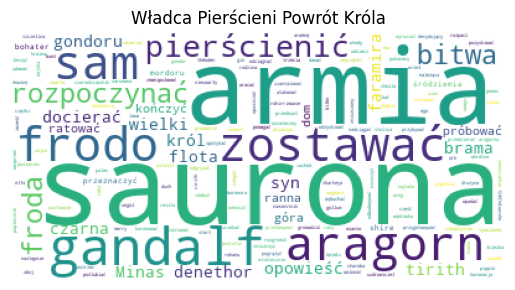

In [72]:
wordcloud = WordCloud(
    background_color="white",
    max_words=5000,
    contour_width=3, 
    contour_color="steelblue"
)
for index, row in docs.iterrows():
    wordcloud.generate(row['content'])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(index.replace(".txt", ""))
    plt.savefig("./wordclouds/{}".format(index.replace(".txt", ".png")))

W tej części notebooka generowane są **chmury tagów (wordclouds)** dla każdego dokumentu w korpusie. Pozwala to szybko wizualnie zidentyfikować najczęściej występujące słowa w poszczególnych streszczeniach książek. Chmury tagów są zapisywane jako pliki PNG w folderze "wordclouds".

# Topic modelling

In [73]:
def plot_top_words(model, feature_names, n_top_words, title, subplots):
    fig, axes = plt.subplots(*subplots, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(f"./topics/{title}.png")

In [74]:
n_components = 5
feature_names = count_vectorizer.get_feature_names_out()
n_top_features = 20
size = [1,5]

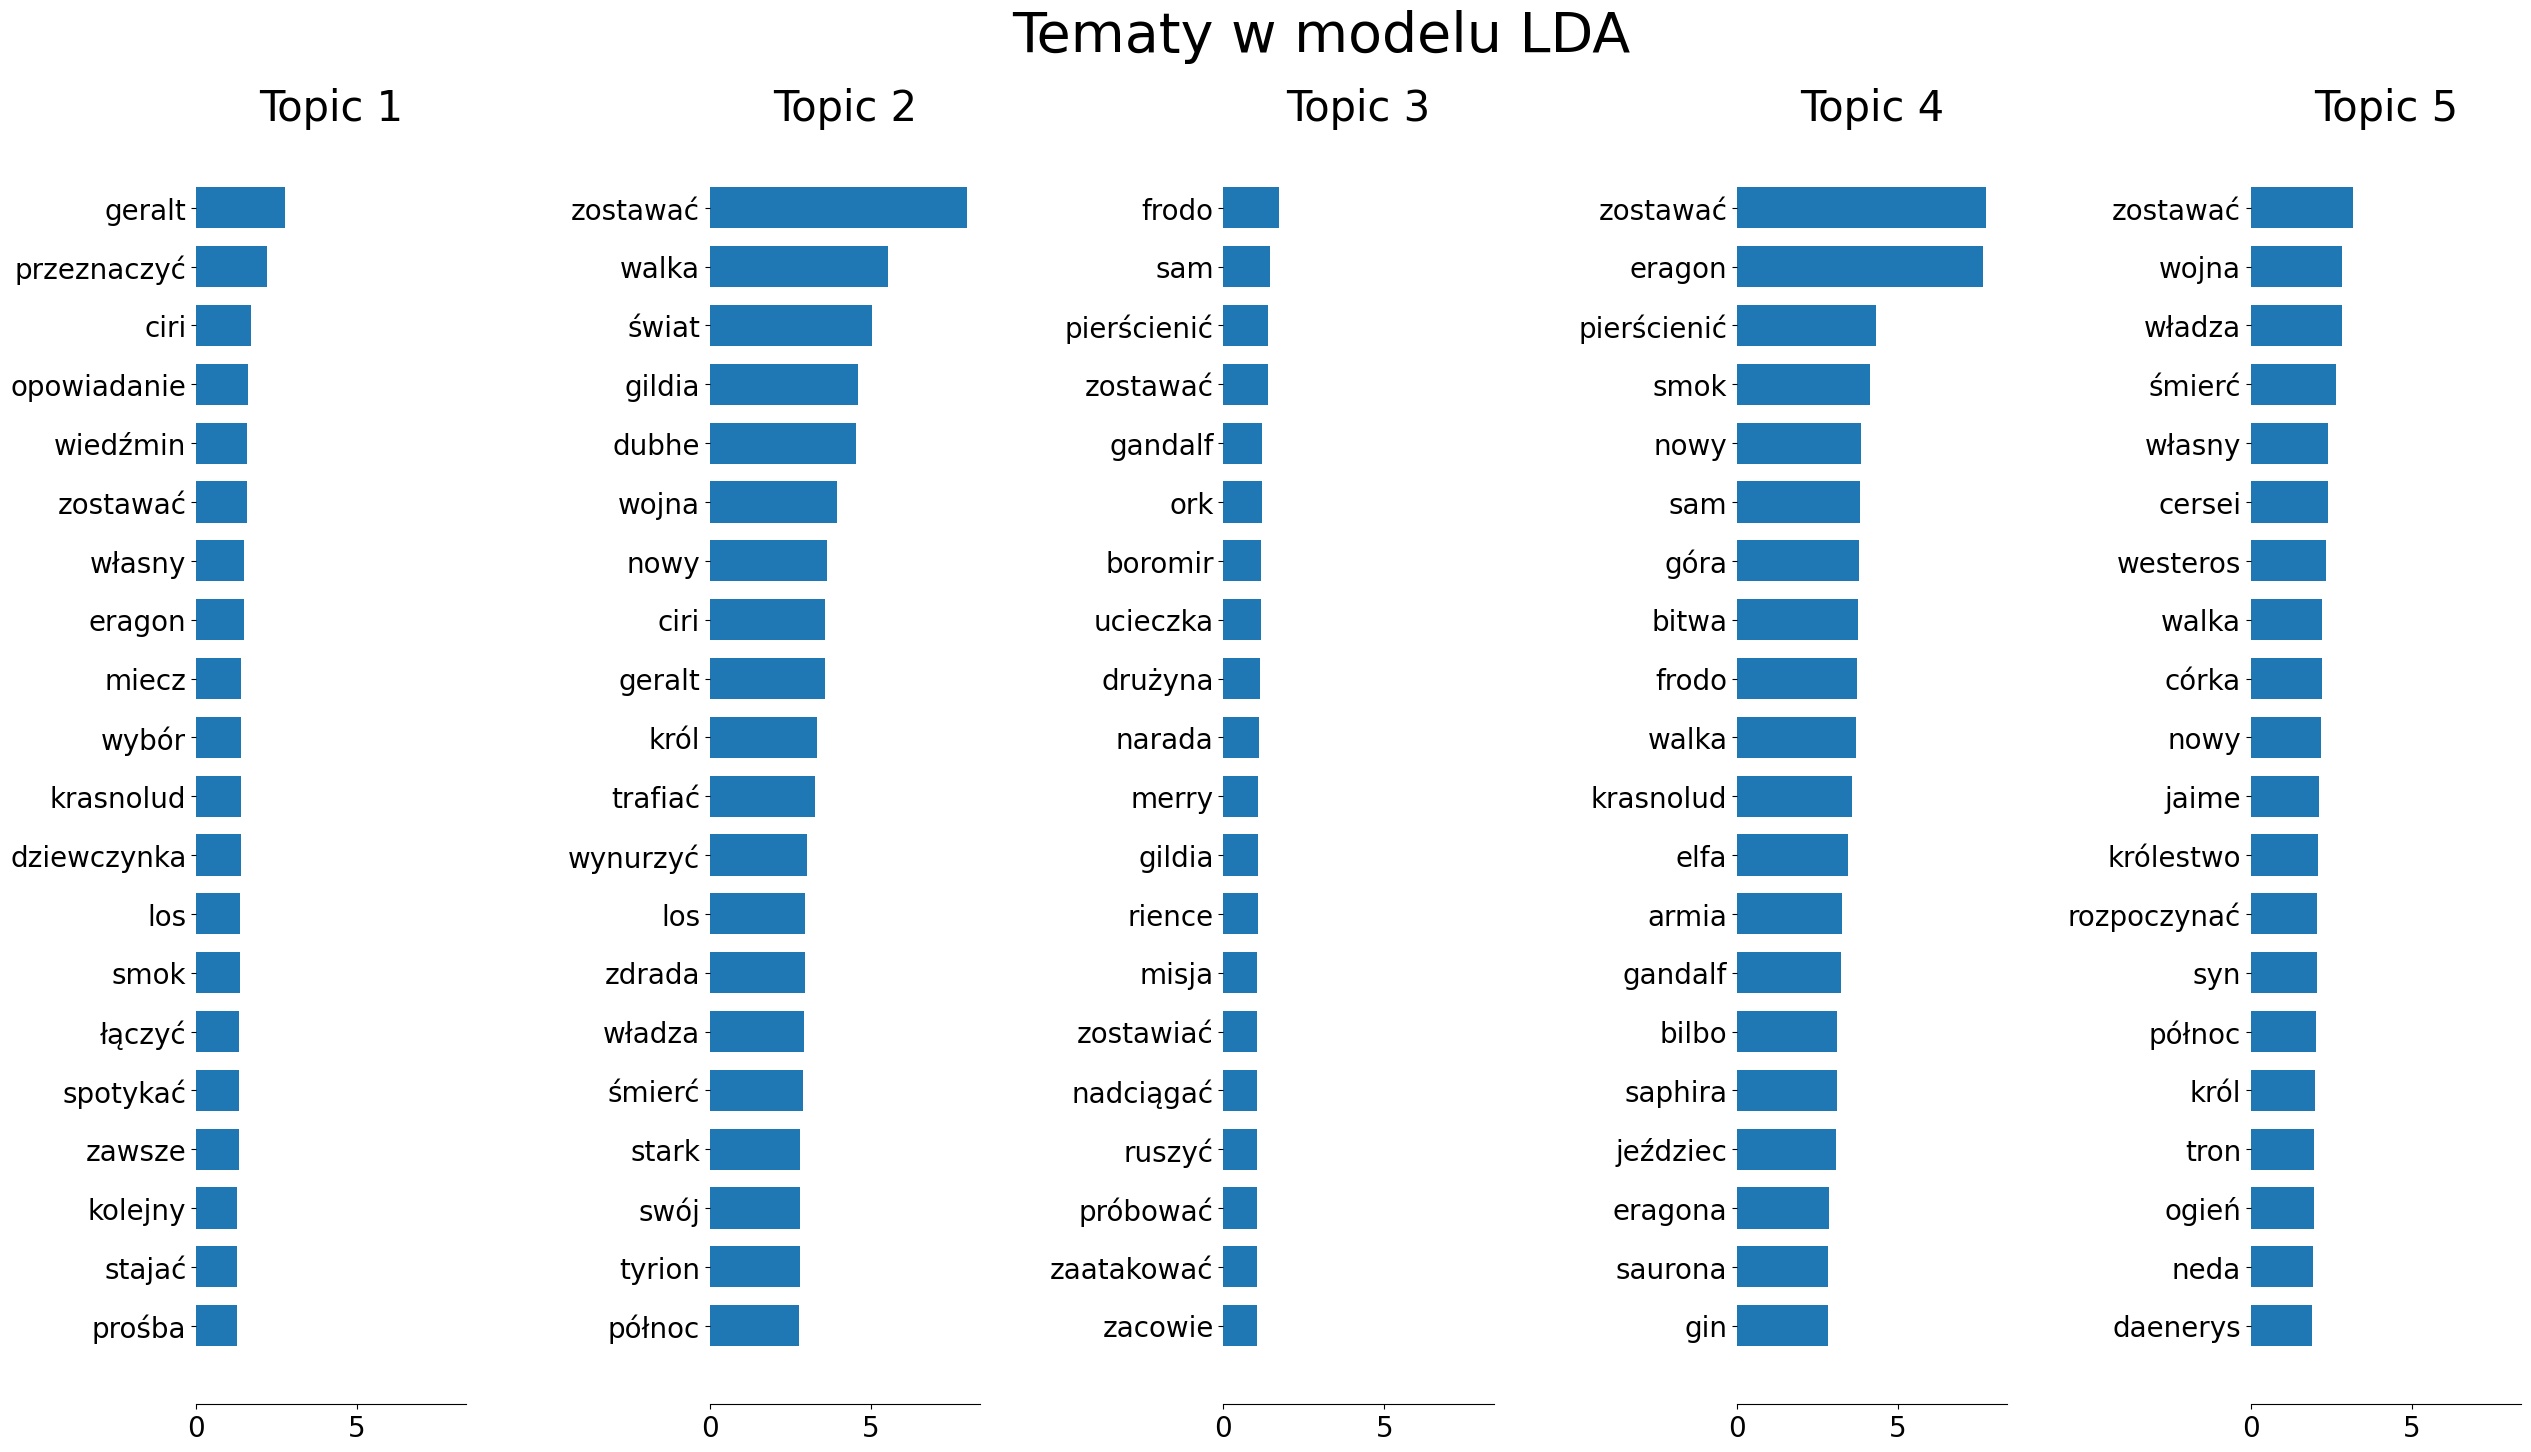

In [76]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method='online',
    learning_offset=50,
    random_state=0
)
lda.fit(counts_tf)
plot_top_words(lda, feature_names, n_top_features, "Tematy w modelu LDA", size)

Używamy **algorytmu LDA**, aby automatycznie odkryć 5 głównych tematów w naszych dokumentach, co powinno odpowiadać 5 sagom książkowym. Poniższa wizualizacja przedstawia najważniejsze słowa tworzące każdy z odkrytych tematów, co pozwala nam na ich interpretację.

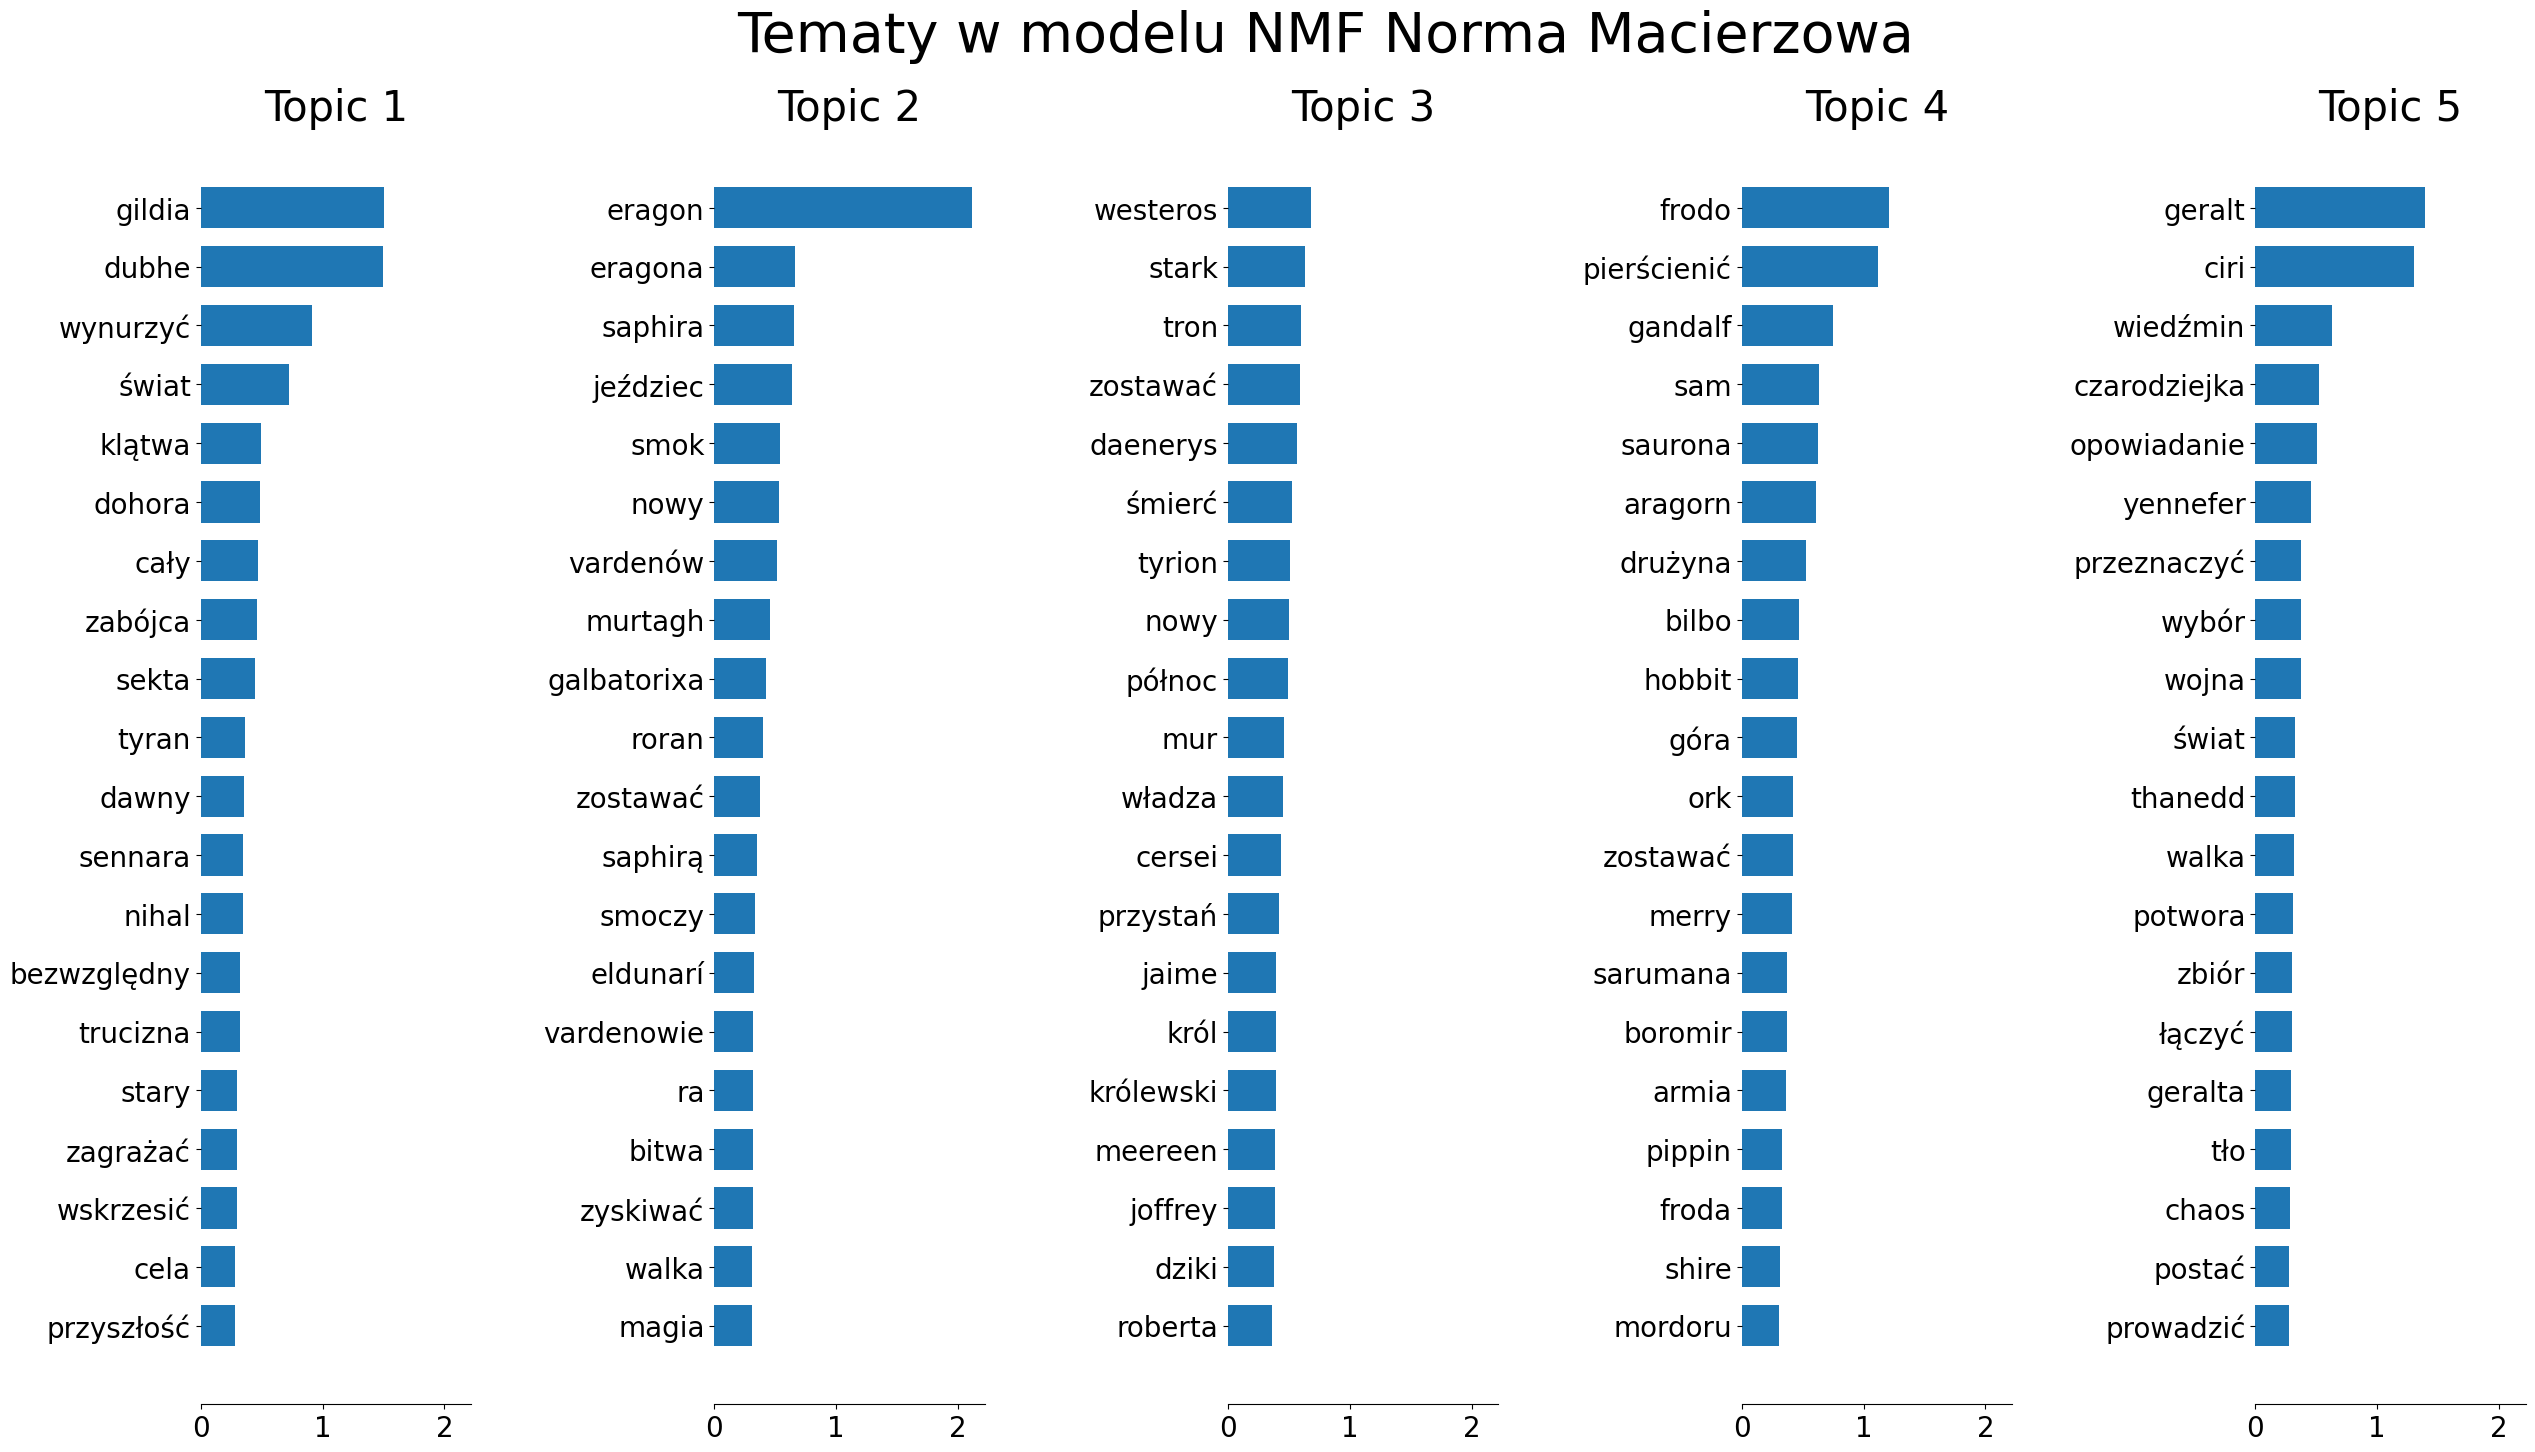

In [77]:
nmf_fm = NMF(
    n_components=n_components,
    random_state=1, 
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_fm.fit(counts_tfidf)
plot_top_words(nmf_fm, feature_names, n_top_features, "Tematy w modelu NMF Norma Macierzowa", size)

Testujemy również **algorytm NMF** na macierzy TF-IDF, który często daje bardziej spójne tematy niż LDA. Wyniki pokazują, że model NMF lepiej zidentyfikował 5 tematów, z których każdy odpowiada jednej z analizowanych sag książkowych.

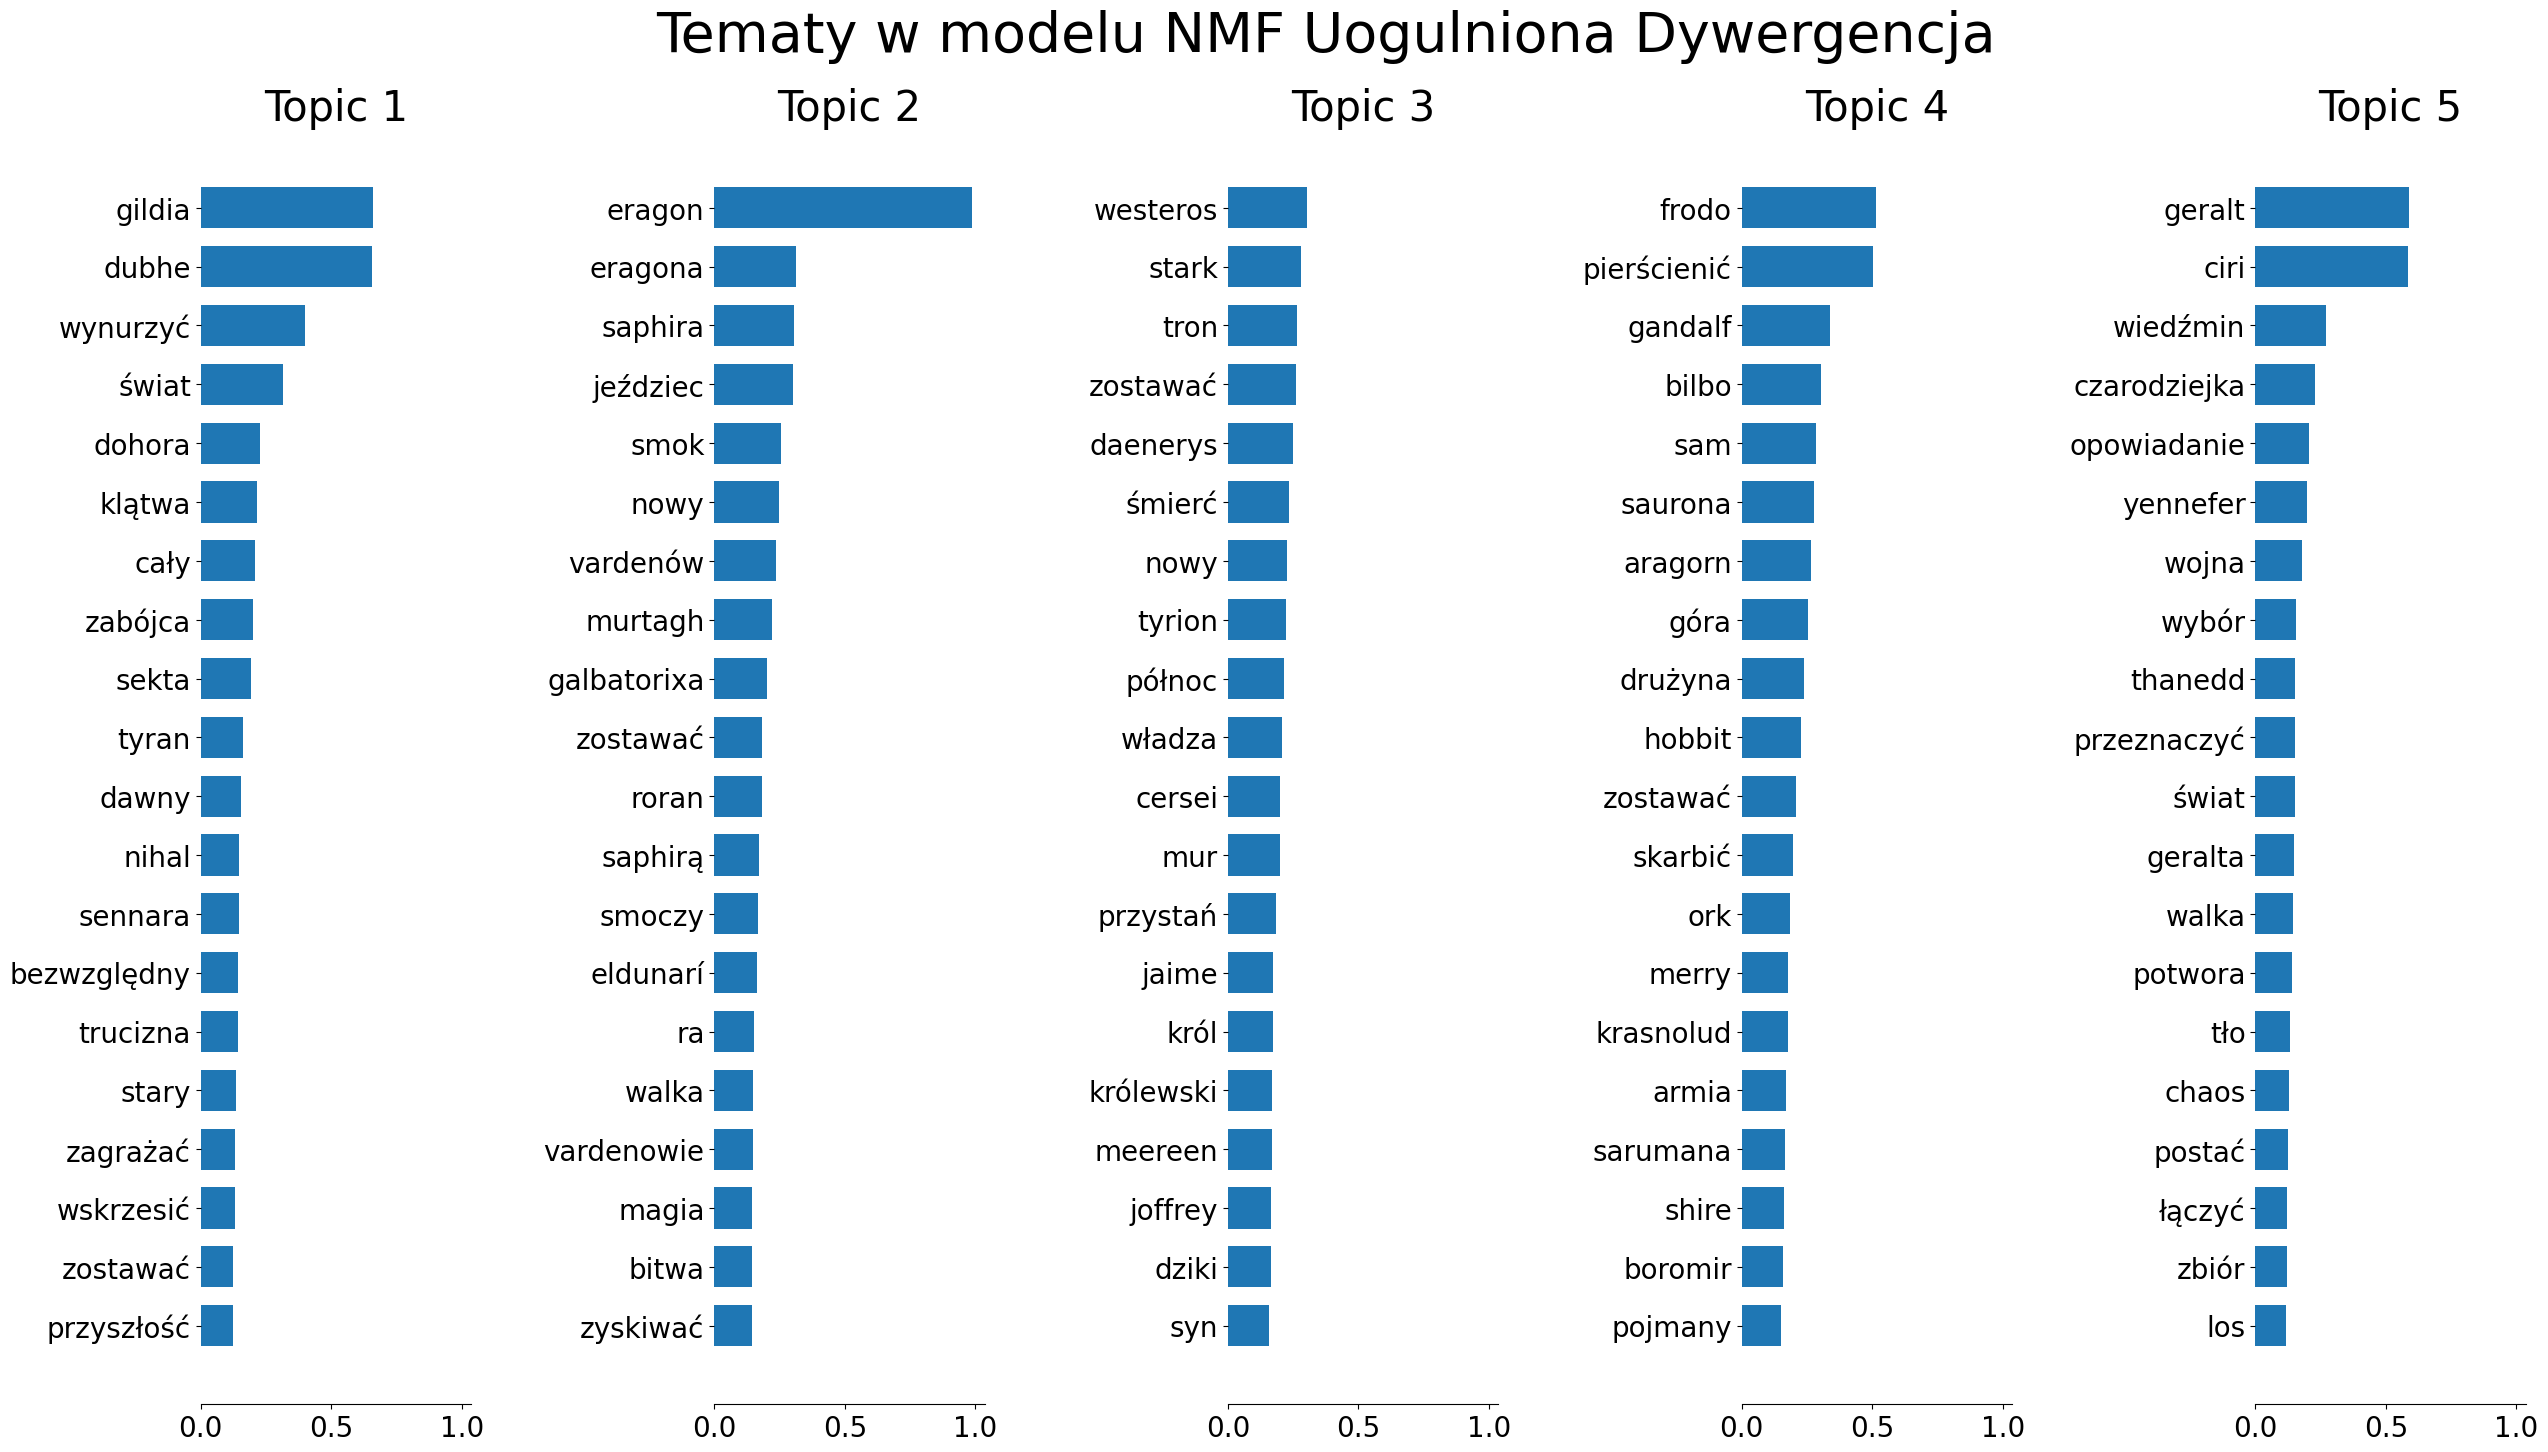

In [85]:
nmf_kl = NMF(
    n_components=n_components,
    random_state=1, 
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_kl.fit(counts_tfidf)
plot_top_words(nmf_kl, feature_names, n_top_features, "Tematy w modelu NMF Uogulniona Dywergencja", size)

Sprawdzamy również działanie NMF z inną funkcją straty – **dywergencją Kullbacka-Leiblera**, która jest często stosowana w modelowaniu tematycznym. Wyniki są bardzo podobne do poprzedniego modelu, co potwierdza, że NMF skutecznie separuje nasze sagi książkowe na spójne tematy.

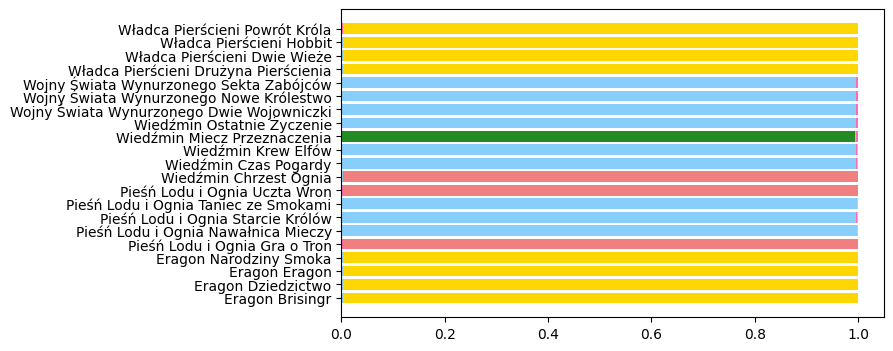

In [86]:
docs_topics = pd.DataFrame(lda.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'])
docs_topics.index = [file_name.replace(".txt", "") for file_name in files_names]
plt.figure(figsize=(7,4))
colors = ['forestgreen', 'lightskyblue', 'hotpink', 'gold', 'lightcoral']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left=left, label=col, color=colors[i])
    left=[left[j]+docs_topics[col].iloc[j] for j in range(len(docs_topics))]

Aby zwizualizować, jak tematy rozkładają się w poszczególnych książkach, tworzymy skumulowany wykres słupkowy. Każdy pasek reprezentuje jeden dokument, a kolory pokazują procentowy udział każdego z 5 odkrytych tematów w danym tekście. Wykres wyraźnie pokazuje, że książki z tej samej sagi są zdominowane przez jeden, spójny temat (kolor).

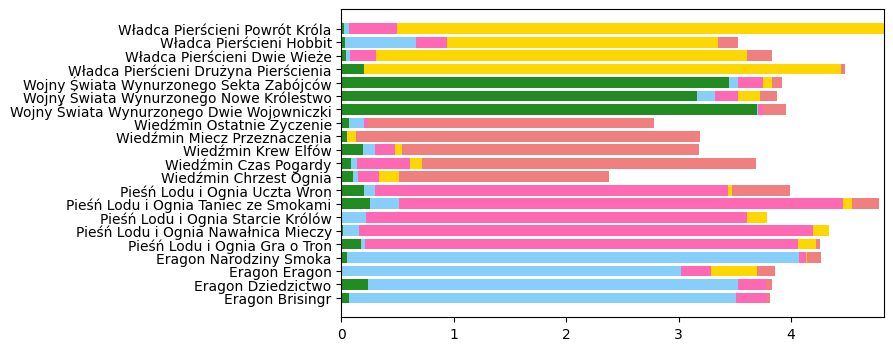

In [87]:
docs_topics = pd.DataFrame(nmf_fm.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'])
docs_topics.index = [file_name.replace(".txt", "") for file_name in files_names]
plt.figure(figsize=(7,4))
colors = ['forestgreen', 'lightskyblue', 'hotpink', 'gold', 'lightcoral']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left=left, label=col, color=colors[i])
    left=[left[j]+docs_topics[col].iloc[j] for j in range(len(docs_topics))]

Analogiczny wykres tworzymy dla wyników z modelu NMF. Wizualizacja ta jeszcze wyraźniej pokazuje dominację jednego tematu (koloru) w obrębie każdej sagi, co potwierdza, że NMF dokonał czystszej separacji tematycznej niż LDA na tym zbiorze danych.

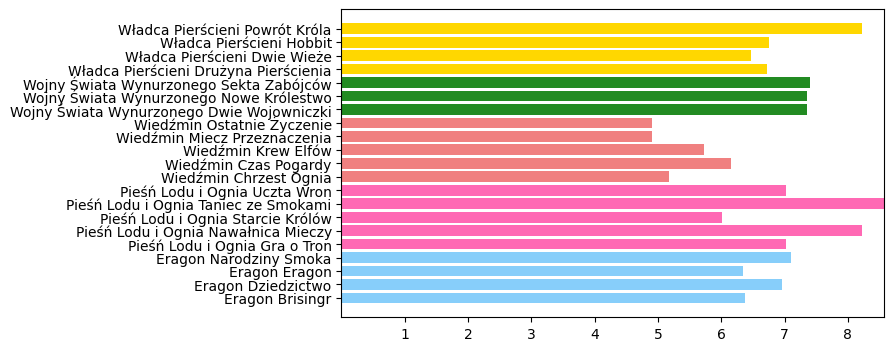

In [88]:
docs_topics = pd.DataFrame(nmf_kl.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'])
docs_topics.index = [file_name.replace(".txt", "") for file_name in files_names]
plt.figure(figsize=(7,4))
colors = ['forestgreen', 'lightskyblue', 'hotpink', 'gold', 'lightcoral']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left=left, label=col, color=colors[i])
    left=[left[j]+docs_topics[col].iloc[j] for j in range(len(docs_topics))]

Wykres dla modelu NMF z dywergencją Kullbacka-Leiblera prezentuje niemal idealną separację tematyczną. Każdy dokument jest przypisany niemal w 100% do jednego, właściwego tematu, co potwierdza, że ta konfiguracja NMF najlepiej poradziła sobie z zadaniem grupowania.

# Analiza skupień

In [89]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [90]:
cs = cosine_similarity(counts_tfidf, counts_tfidf).flatten().reshape(21,21)
cs

array([[1.        , 0.34727827, 0.3274558 , 0.44270426, 0.06598988,
        0.08905494, 0.09103797, 0.09889793, 0.08573661, 0.04680106,
        0.04908377, 0.04334678, 0.04985887, 0.0629619 , 0.04679075,
        0.06867525, 0.05284637, 0.03865001, 0.06826932, 0.08153393,
        0.05347534],
       [0.34727827, 1.        , 0.28125363, 0.36563476, 0.06313637,
        0.05601624, 0.07559482, 0.10674525, 0.07567241, 0.05148134,
        0.05379281, 0.04962458, 0.03067259, 0.06837817, 0.06004463,
        0.09813676, 0.0581297 , 0.05359944, 0.05238627, 0.06572848,
        0.04802925],
       [0.3274558 , 0.28125363, 1.        , 0.39018536, 0.08007616,
        0.07975535, 0.12199789, 0.06698553, 0.0607967 , 0.04055034,
        0.059801  , 0.08141448, 0.06543402, 0.06368816, 0.03879089,
        0.0508498 , 0.05202264, 0.09287992, 0.07789612, 0.14989747,
        0.08995978],
       [0.44270426, 0.36563476, 0.39018536, 1.        , 0.04762816,
        0.06544332, 0.07497714, 0.06733576, 0.0756441

In [91]:
clusering = AgglomerativeClustering(
    n_clusters=3,
    metric="euclidean",
    linkage="ward",
    compute_distances=True
).fit(cs)
clusering.labels_

array([1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

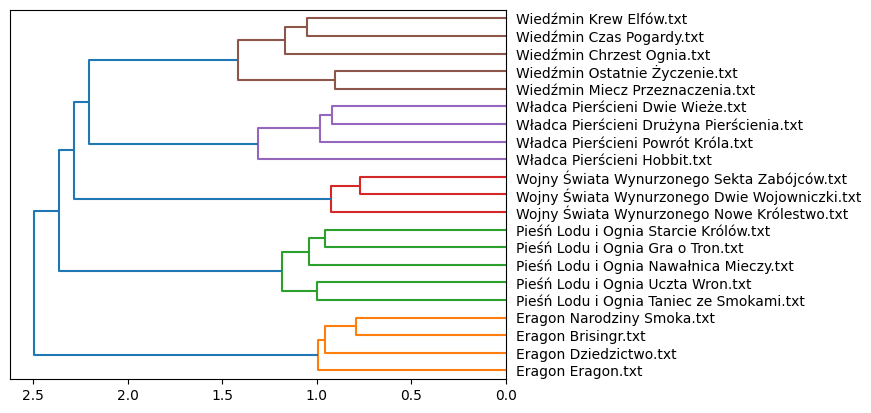

In [92]:
plot_dendrogram(
    clusering,
    labels = files_names,
    truncate_mode = 'level',
    orientation = 'left'
)
plt.show()

Przeprowadzamy **klastrowanie hierarchiczne**, aby sprawdzić, jak dokumenty grupują się na podstawie ich podobieństwa tekstowego. Wynikowy dendrogram potwierdza, że algorytm skutecznie zidentyfikował poszczególne sagi, łącząc należące do nich książki w spójne klastry.

In [93]:
ed = euclidean_distances(counts_tf, counts_tf).flatten().reshape(21,21)
ed

array([[ 0.        , 17.94435844, 18.1934054 , 17.49285568, 24.20743687,
        24.12467616, 21.9089023 , 24.22808288, 22.71563338, 20.76053949,
        22.5166605 , 21.61018278, 21.97726098, 20.80865205, 22.44994432,
        21.30727575, 22.24859546, 24.53568829, 21.74856317, 23.38803113,
        25.57342371],
       [17.94435844,  0.        , 19.5192213 , 18.81488772, 24.69817807,
        25.25866188, 22.6715681 , 24.06241883, 23.23790008, 21.09502311,
        23.08679276, 22.06807649, 22.737634  , 21.1896201 , 22.627417  ,
        21.30727575, 22.5166605 , 24.81934729, 22.60530911, 24.10394159,
        26.38181192],
       [18.1934054 , 19.5192213 ,  0.        , 18.41195264, 23.51595203,
        23.8117618 , 20.95232684, 24.77902339, 23.2594067 , 20.78460969,
        22.22611077, 20.73644135, 21.49418526, 20.68816087, 22.737634  ,
        21.47091055, 21.81742423, 23.21637353, 21.49418526, 21.86321111,
        24.51530134],
       [17.49285568, 18.81488772, 18.41195264,  0.        

In [94]:
clusering = AgglomerativeClustering(
    n_clusters=3,
    metric="precomputed",
    linkage="complete",
    compute_distances=True
).fit(ed)
clusering.labels_

array([0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1])

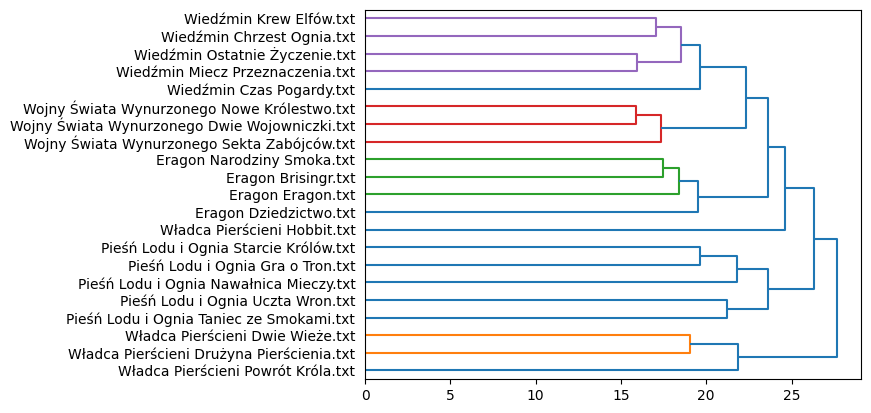

In [95]:
plot_dendrogram(
    clusering,
    labels = files_names,
    truncate_mode = 'level',
    orientation = 'right'
)
plt.show()

Kolejna próba klastrowania, tym razem wykorzystująca dystans Euklidesa na macierzy częstości oraz metodę łączenia "complete". Wynikowy dendrogram pokazuje inną, mniej wyraźną strukturę grup niż w poprzednim podejściu.

# N-gramy

In [96]:
documents_tokenized = {}
for key in documents:
    documents_tokenized[key] = word_tokenize(documents[key], language='polish')
print(json.dumps(documents_tokenized, indent=4, ensure_ascii=False))  

{
    "Eragon Brisingr.txt": [
        "eragon",
        "młody",
        "jeździec",
        "smok",
        "saphirą",
        "kuzyna",
        "roranem",
        "wyruszać",
        "helgrindu",
        "uratować",
        "porwać",
        "ra",
        "zac",
        "narzeczona",
        "rorana",
        "katrinę",
        "dramatyczny",
        "walka",
        "udawać",
        "pokonać",
        "potwora",
        "uwolnić",
        "dziewczyna",
        "eragon",
        "zostawać",
        "rozstrzygnąć",
        "los",
        "ojciec",
        "sloana",
        "ostatecznie",
        "skazywać",
        "wygnać",
        "powrót",
        "vardenów",
        "roran",
        "zyskiwać",
        "sława",
        "dzięki",
        "odwaga",
        "popadać",
        "konflikt",
        "dowództwo",
        "kończyć",
        "awans",
        "dowódca",
        "oddział",
        "czas",
        "eragon",
        "udawać",
        "krasnolud",
        "zostawać",
        "

Eragon Brisingr.txt


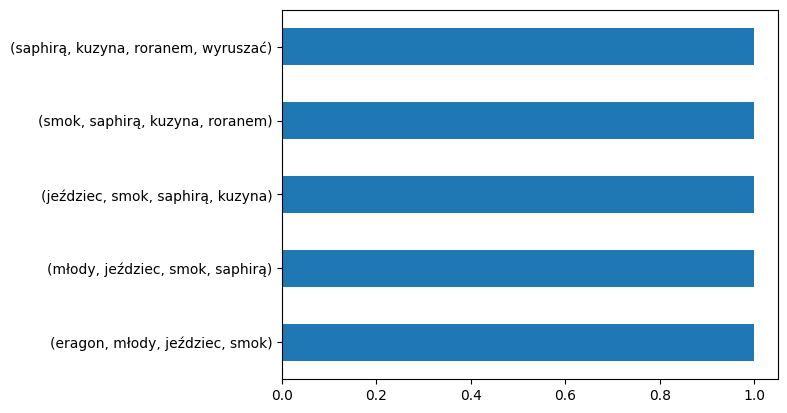

Eragon Dziedzictwo.txt


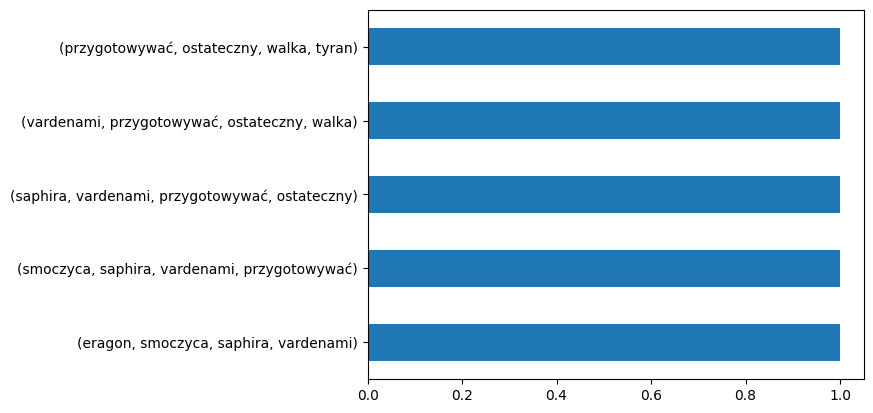

Eragon Eragon.txt


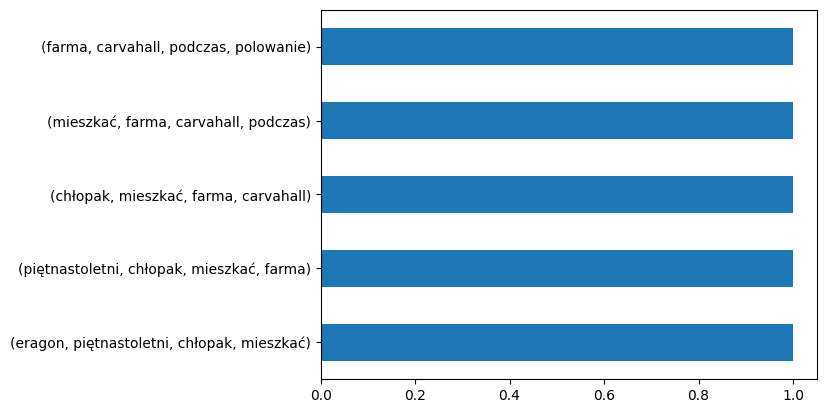

Eragon Narodziny Smoka.txt


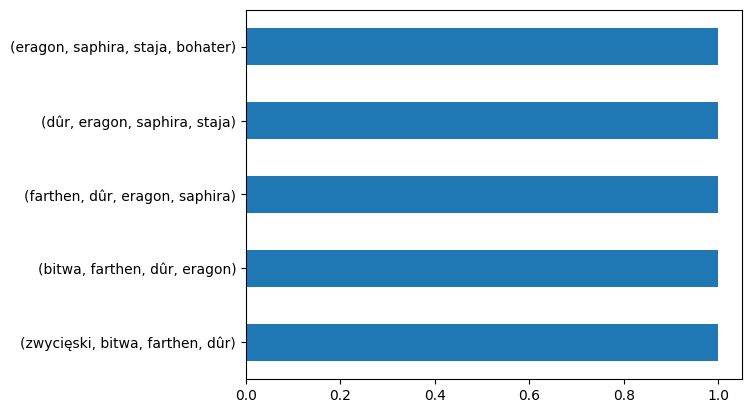

Pieśń Lodu i Ognia Gra o Tron.txt


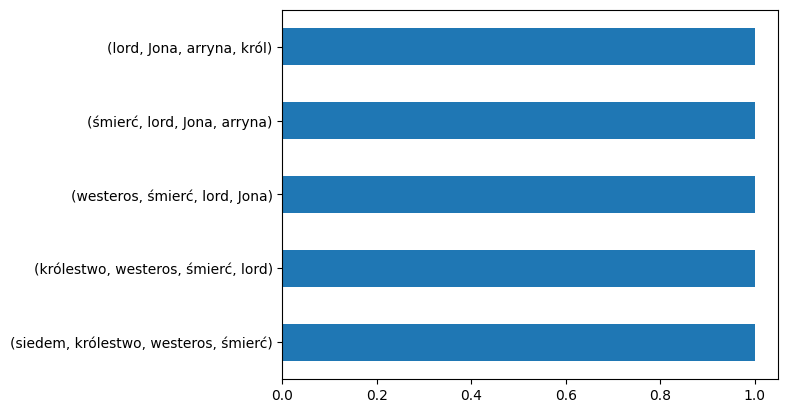

Pieśń Lodu i Ognia Nawałnica Mieczy.txt


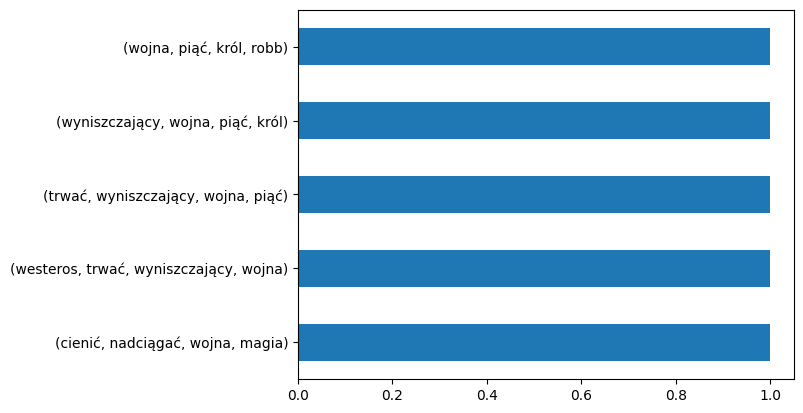

Pieśń Lodu i Ognia Starcie Królów.txt


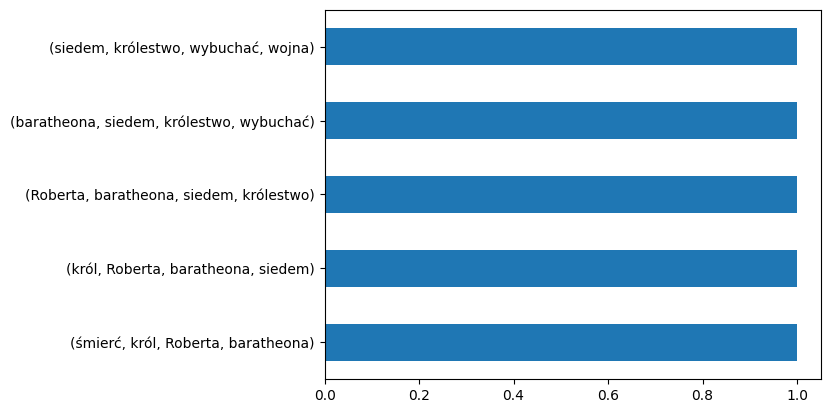

Pieśń Lodu i Ognia Taniec ze Smokami.txt


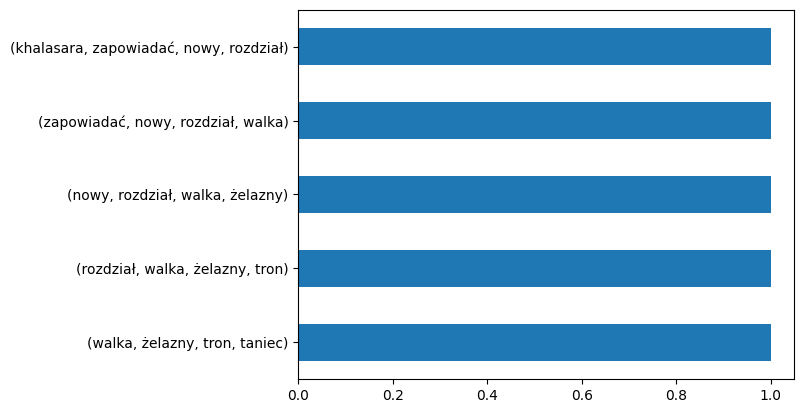

Pieśń Lodu i Ognia Uczta Wron.txt


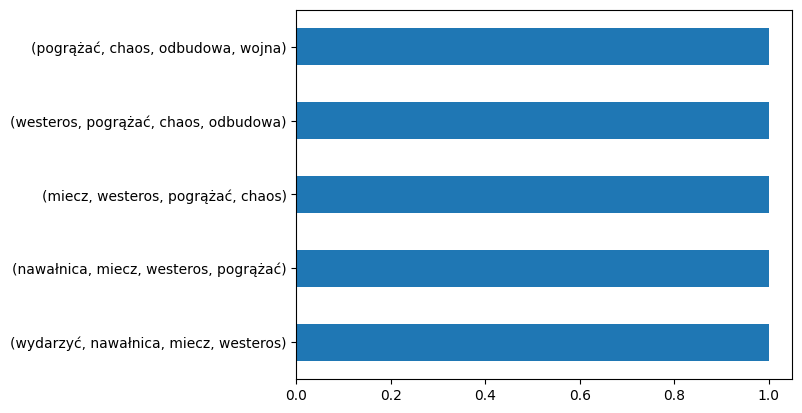

Wiedźmin Chrzest Ognia.txt


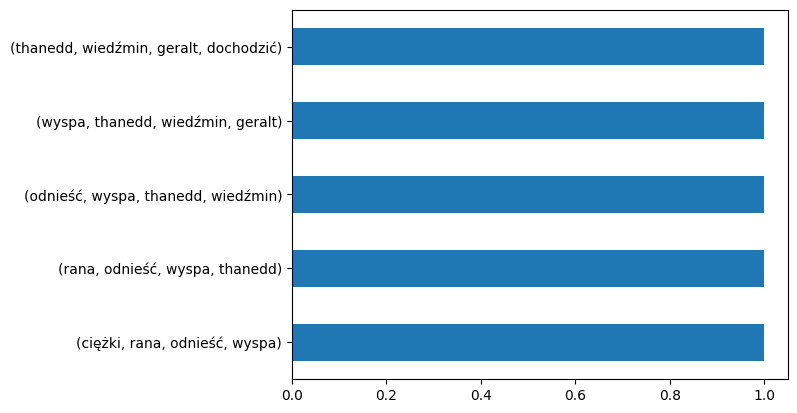

Wiedźmin Czas Pogardy.txt


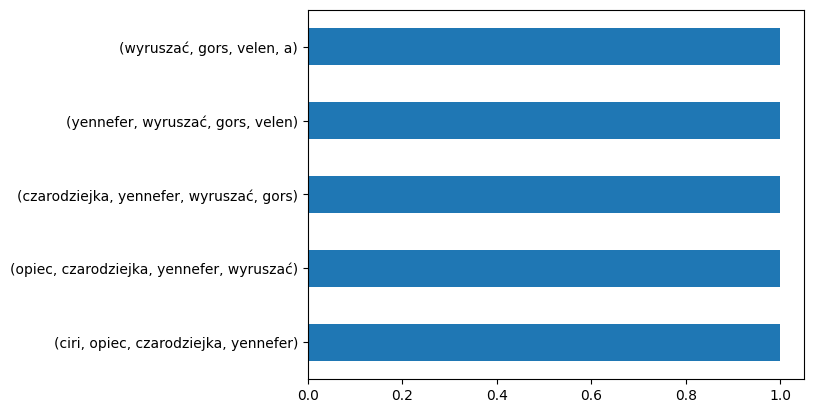

Wiedźmin Krew Elfów.txt


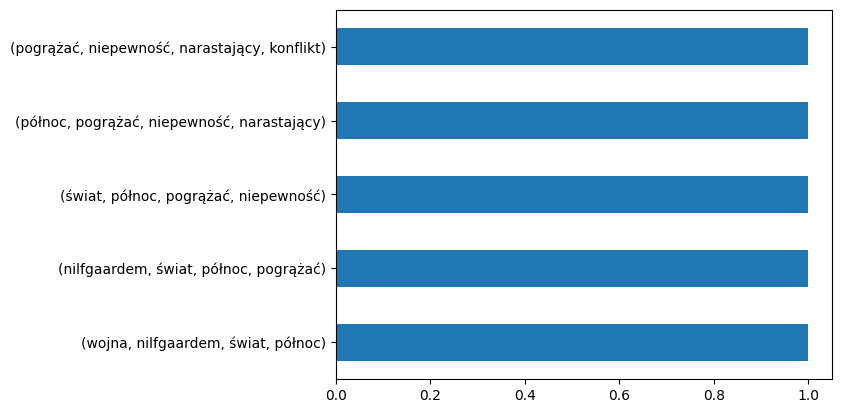

Wiedźmin Miecz Przeznaczenia.txt


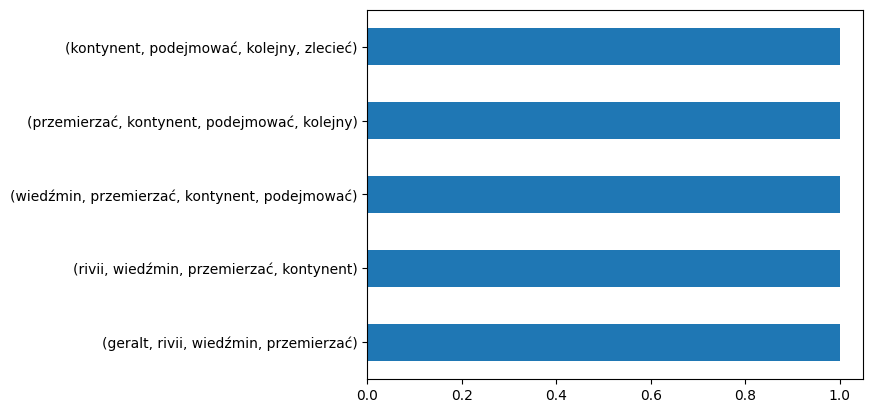

Wiedźmin Ostatnie Życzenie.txt


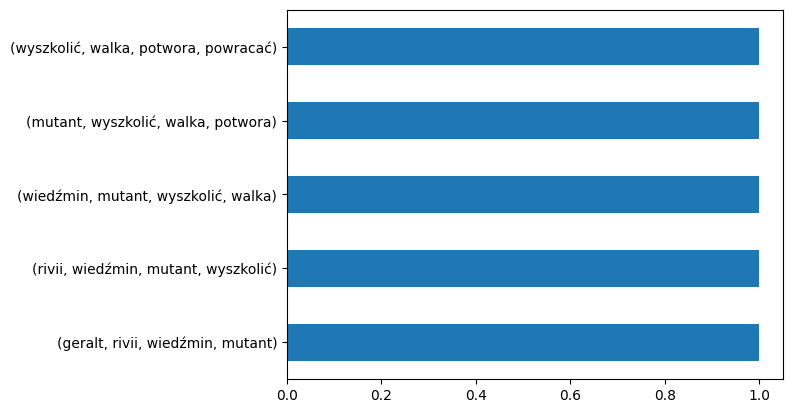

Wojny Świata Wynurzonego Dwie Wojowniczki.txt


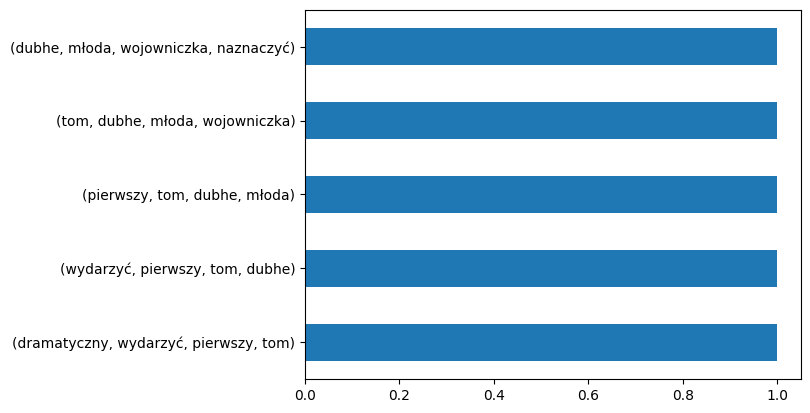

Wojny Świata Wynurzonego Nowe Królestwo.txt


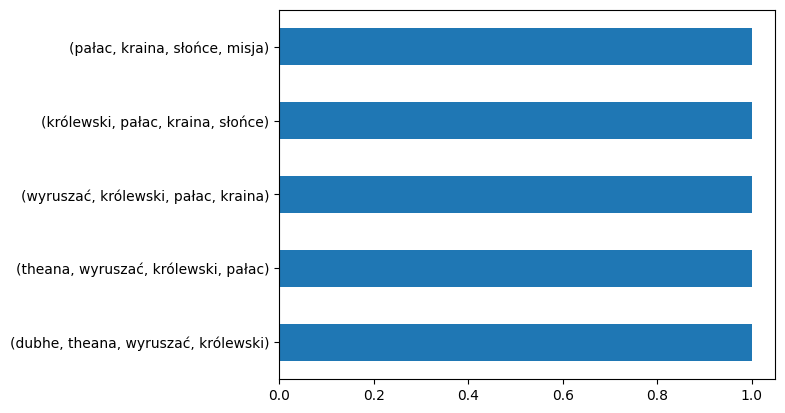

Wojny Świata Wynurzonego Sekta Zabójców.txt


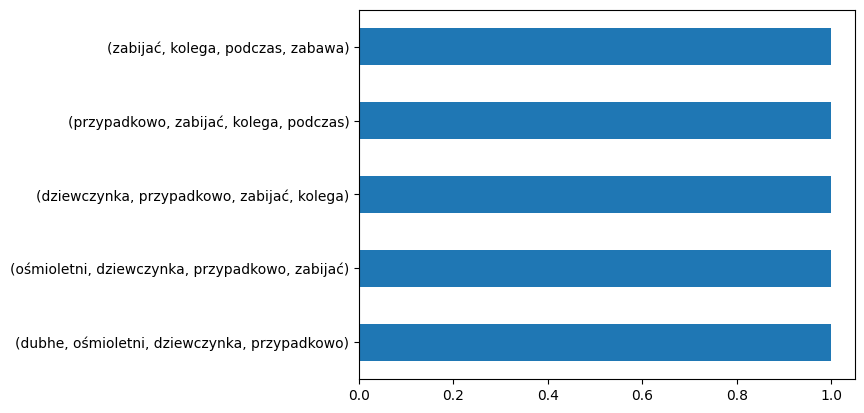

Władca Pierścieni Drużyna Pierścienia.txt


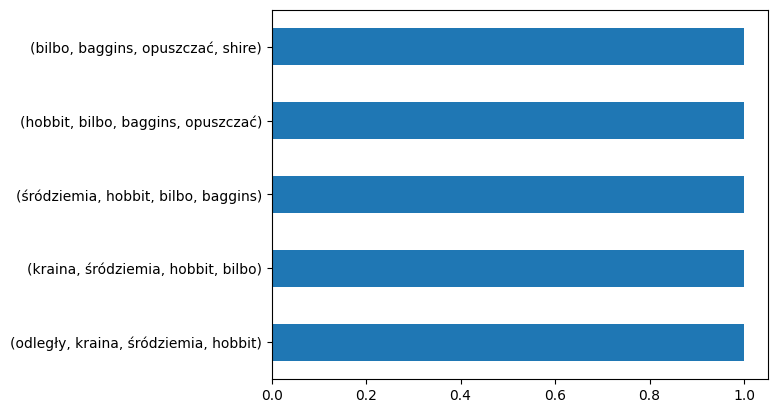

Władca Pierścieni Dwie Wieże.txt


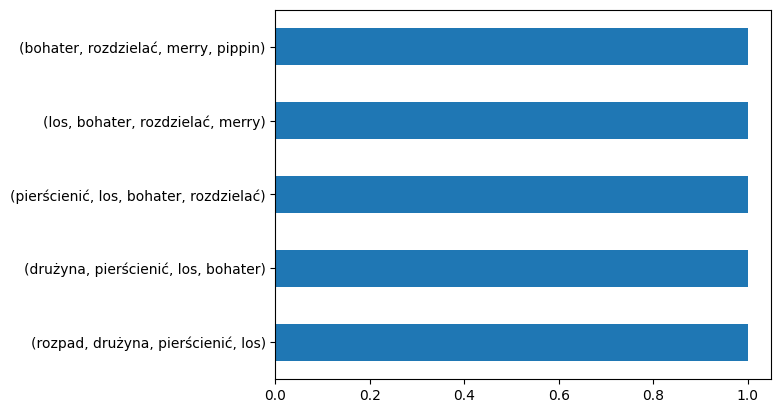

Władca Pierścieni Hobbit.txt


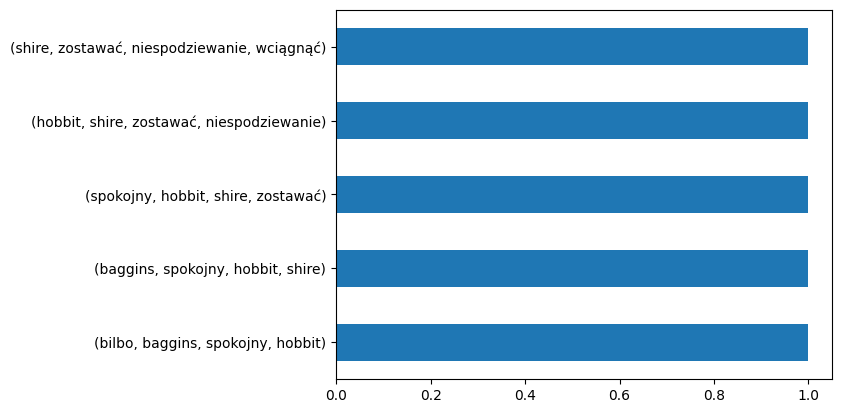

Władca Pierścieni Powrót Króla.txt


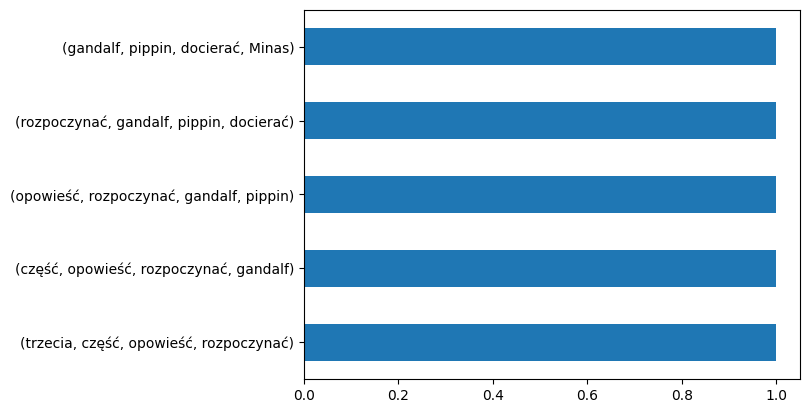

In [97]:
for title in documents_tokenized:
    n_gram = pd.Series(ngrams(documents_tokenized[title], 4)).value_counts()
    print(title)
    n_gram[:5].plot.barh()
    plt.show()

Analiza N-gramów (w tym przypadku 4-gramów), pozwala znaleźć charakterystyczne, powtarzające się sekwencje słów. Wizualizacje pokazują 5 najczęstszych fraz dla każdej książki, co pozwala uchwycić kontekst i styl danego tekstu, który jest niewidoczny przy analizie pojedynczych słów. Jak widać, w streszczeniach rzadko występują powtarzalne, długie frazy (częstość wynosi 1), ale mimo to analiza ta pokazuje przykładowe sekwencje słów typowe dla każdej z książek.

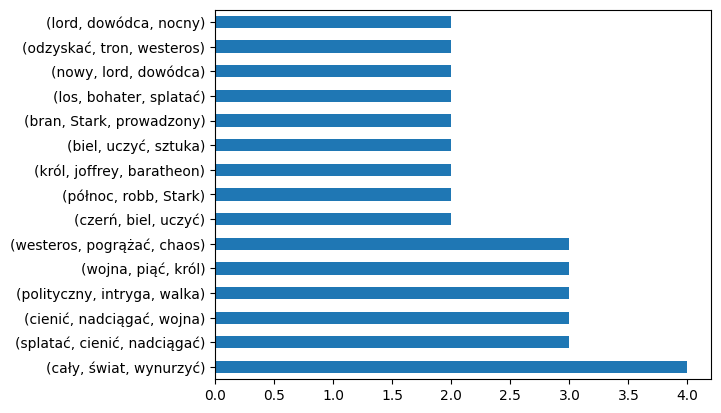

In [98]:
texts = ' '.join(docs['content']).split(" ")
n_gram = pd.Series(ngrams(texts, 3)).value_counts()
n_gram[:15].plot.barh()
plt.show()

Aby zidentyfikować charakterystyczne zwroty dla całego zbioru, można przeanalizować 3-gramy na połączonych tekstach wszystkich książek. Wykres przedstawia 15 najczęstszych fraz, z których wiele, jak `(król, joffrey, baratheon)`, jednoznacznie wskazuje na sagę "Pieśń Lodu i Ognia".